# Scenario 1: All modalities exists, no heterginity

In [1]:
import os
import torch
import torch.cuda as cuda
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms as transf
from torchsummary import summary
import numpy as np
import pandas as pd

from data_feed import DataFeed, DataFeed_image_pos
from build_net import resnet50, NN_beam_pred
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
val_batch_size = 1
lr = 1e-3
decay = 1e-4
num_epochs = 20
train_size = [1]
no_users = 20

In [3]:
########################################################################
########################### Data pre-processing ########################
########################################################################


img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)
dataset_dir = "feature_IID/"
train_loaders = []
test_loaders = []
val_loaders = []

for user_id in range(no_users):
    train_dir = dataset_dir + f'user_{user_id}_pos_height_beam_train.csv'
    val_dir = dataset_dir + f'user_{user_id}_pos_height_beam_val.csv'
    test_dir = dataset_dir + f'user_{user_id}_pos_height_beam_test.csv'
    
    train_dataset = DataFeed_image_pos(train_dir, transform=proc_pipe)
    val_dataset = DataFeed_image_pos(root_dir=val_dir, transform=proc_pipe)
    test_dataset = DataFeed_image_pos(root_dir=test_dir, transform=proc_pipe)
    
    
    train_loaders.append(DataLoader(train_dataset,
                              batch_size=batch_size,
                              #num_workers=8,
                              shuffle=False))
    val_loaders.append(DataLoader(val_dataset,
                            batch_size=val_batch_size,
                            #num_workers=8,
                            shuffle=False))
    test_loaders.append(DataLoader(test_dataset,
                            batch_size=val_batch_size,
                            #num_workers=8,
                            shuffle=False))
    print(f"Loaded_user: {user_id}")

Loaded_user: 0
Loaded_user: 1
Loaded_user: 2
Loaded_user: 3
Loaded_user: 4
Loaded_user: 5
Loaded_user: 6
Loaded_user: 7
Loaded_user: 8
Loaded_user: 9
Loaded_user: 10
Loaded_user: 11
Loaded_user: 12
Loaded_user: 13
Loaded_user: 14
Loaded_user: 15
Loaded_user: 16
Loaded_user: 17
Loaded_user: 18
Loaded_user: 19


In [4]:
for _, (x, y) in zip(range(1), train_loaders[0]):
    print(x["pos_height"].shape)

torch.Size([64, 4])


In [5]:
# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
user_modalities = [available_modalities for _ in range(no_users)]
for user_id in range(no_users):
    user_model = {}
    if "images" in user_modalities[user_id]:
        user_model["images"] = resnet50(pretrained=True, progress=True, num_classes=64)
    if "pos_height" in user_modalities[user_id]:
        user_model["pos_height"] = NN_beam_pred(num_features=4, num_output=64)
    all_models.append(user_model)
    

Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottle

In [7]:
# Create a connected random topology using NetworkX
def create_random_topology(num_users=no_users, edge_probability=0.3, modalities=user_modalities):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix and mixing matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        if nx.is_connected(graph):
            break

    # Plot the graph (optional)
    nx.draw(graph, with_labels=True, node_color="lightblue", font_weight="bold")
    plt.title("Random Connected Topology")
    plt.show()

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(graph)

    # Create mixing matrix (row stochastic)
    mixing_matrix = adjacency_matrix / adjacency_matrix.sum(axis=1, keepdims=True)
    return adjacency_matrix, mixing_matrix

# Decentralized aggregation function
def decentralized_aggregation(user_models, mixing_matrix):
    """
    Aggregates user models based on the mixing matrix.
    """
    num_users = len(user_models)
    aggregated_models = [t.nn.utils.parameters_to_vector(user_model.parameters()) for user_model in user_models]
    aggregated_updates = [t.zeros_like(aggregated_models[0]) for _ in range(num_users)]

    for i in range(num_users):
        for j in range(num_users):
            if mixing_matrix[i, j] > 0:
                aggregated_updates[i] += mixing_matrix[i, j] * aggregated_models[j]

    # Update user models with aggregated parameters
    for i in range(num_users):
        t.nn.utils.vector_to_parameters(aggregated_updates[i], user_models[i].parameters())

def train_local_model(local_modalities, models, train_loader, criterion, optimizers, epochs):

    for modality in local_modalities:
        print(f"Training for modality: {modality}")
        
        model = models[modality]
        optimizer = optimizers[modality]
        
        model.train()
        for epoch in range(epochs):
            for data, labels in train_loader:
                # Move data to GPU if available
                data = data[modality]
                data, labels = data, labels#data.cuda(), labels.cuda()
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                _, outputs = model(data)

                if modality == "images":
                    print(type(outputs))
                
                # Compute loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Optional: Print loss for debugging
                print(f"Epoch [{epoch + 1}/{epochs}], Modality: {modality}, Loss: {loss.item():.4f}")
    
    return models



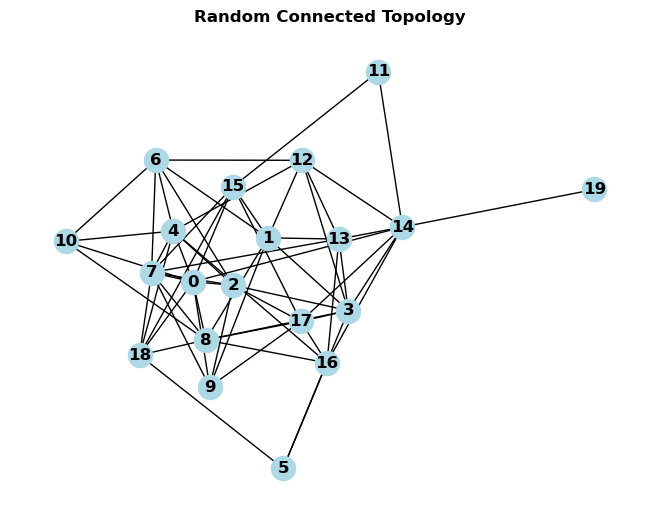

Global Round 1
Training image modalitity models
Training model for User 1
Training for modality: pos_height
Epoch [1/1], Modality: pos_height, Loss: 4.1459
Epoch [1/1], Modality: pos_height, Loss: 4.0602
Epoch [1/1], Modality: pos_height, Loss: 3.9188
Epoch [1/1], Modality: pos_height, Loss: 3.7203
Epoch [1/1], Modality: pos_height, Loss: 3.6376
Epoch [1/1], Modality: pos_height, Loss: 3.4379
Epoch [1/1], Modality: pos_height, Loss: 2.8060
Epoch [1/1], Modality: pos_height, Loss: 2.7507
Epoch [1/1], Modality: pos_height, Loss: 3.2476
Epoch [1/1], Modality: pos_height, Loss: 2.9150
Epoch [1/1], Modality: pos_height, Loss: 2.4456
Epoch [1/1], Modality: pos_height, Loss: 3.1145
Epoch [1/1], Modality: pos_height, Loss: 2.7684
Epoch [1/1], Modality: pos_height, Loss: 2.8168
Epoch [1/1], Modality: pos_height, Loss: 2.5815
Epoch [1/1], Modality: pos_height, Loss: 2.9155
Epoch [1/1], Modality: pos_height, Loss: 2.9322
Epoch [1/1], Modality: pos_height, Loss: 2.8120
Epoch [1/1], Modality: pos_h

KeyboardInterrupt: 

In [8]:
# Create random connected topology and mixing matrix
adjacency_matrix, mixing_matrix = create_random_topology(no_users, edge_probability=0.3)
local_epochs = 1
global_rounds = 10
weight_decay = 1e-5
criterion = nn.CrossEntropyLoss()

# Decentralized Training
for round_num in range(global_rounds):
    print(f"Global Round {round_num + 1}")

    # Training for image_modalities 
    print("Training image modalitity models")
    # Train each user's local model
    for user_id in range(no_users):
        print(f"Training model for User {user_id + 1}")
        user_models = all_models[user_id]
        optimizers = {}
        for modality in user_model.keys():
            optimizers[modality] = optim.Adam(user_models[modality].parameters(), lr=lr, weight_decay=weight_decay)
        train_local_model(user_modalities[user_id], user_models, train_loaders[user_id], criterion, optimizers, local_epochs)

    # Decentralized aggregation
    print("Performing decentralized aggregation")
    #decentralized_aggregation(user_models, mixing_matrix)

    # Optionally, validate models
    #print("Validating user models...")
    #for user_id, user_model in enumerate(user_models):
    #    user_model.eval()
    #    # Add validation logic for each user's model here



print("Decentralized federated learning complete.")

In [31]:
model = all_models[0]["images"]
optimizer = optim.Adam(user_models["images"].parameters(), lr=lr, weight_decay=weight_decay)
for data, labels in train_loaders[0]:
    # Move data to GPU if available
    data = data["images"]
    data, labels = data, labels#data.cuda(), labels.cuda()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    _, outputs = model(data)
    print(outputs[1].shape)

torch.Size([64, 64])
torch.Size([64, 64])


KeyboardInterrupt: 